In [1]:
from datetime import datetime
import time
from pathlib import Path
import pandas as pd

# NMF topic analysis 

Run a non-negative matrix factorisation analysis on tool descriptions to discover common themes and domains. 

This is a standalone notebook that can be run, once the data are downloaded using the report. 

For more information on topic extraction, see:
https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

In [2]:
today = datetime.today().strftime('%Y-%m-%d'); today

'2025-07-01'

In [3]:
## Setup

In [4]:
# for text feature exxtraction
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem.regexp import RegexpStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import string

# For NMF
from sklearn.decomposition import NMF


# for post analysis
import numpy as np
from sklearn.metrics import mean_squared_error
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# from main import *
# import pandas as pd
# from collections import Counter
# 
# import numpy as np
# from sklearn.feature_extraction import text

# import seaborn as sns

# from nltk.stem.porter import PorterStemmer
# from nltk.stem.snowball import EnglishStemmer
# from nltk.stem import WordNetLemmatizer 


# import string


In [5]:
# nltk.download('wordnet')

Additional libaries needed to run this notebook are:

* sklearn
* numpy as np

## Loading the data

To download the data from bio.tools, first run the report with mode `extract_and_save`, then update the `load_path` variable below. 

In [6]:
# file_settings for TSV
delim = "\t"
ext = "tsv"

# add the path to the downloaded data file
load_path = Path("data/bio_tools_systems_biology_July_01_2025.tsv")

In [7]:
data = pd.read_csv(load_path, sep="\t")[["name", "description"]]

print(data.shape[0])
data.head()

553


,name,description
0,SwissRegulon,SwissRegulon is a database of genome-wide anno...
1,arrayMap,A curated reference database and bioinformatic...
2,SimBioNeT,Simulator of biological networks topology in w...
3,Zooma,ZOOMA 2 is a search engine for automatic curat...
4,Clusteval,Free and extendable opensource platform for ob...


## Functions

In [8]:
def calc_RMSE(nmf, df):
        W = nmf.fit_transform(df)
        H = nmf.components_
        V = W @ H
        
        # Calculate RMSE of original df and new V
        RMSE = np.sqrt(mean_squared_error(df, V))
        
        return RMSE

In [9]:
def plot_top_words(model, feature_names, n_top_words, title, ncols=5):
    nrows = len(nmf.components_)//ncols
    if nrows*ncols < len(nmf.components_):
        nrows = nrows+1
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right".split():
            ax.spines[i].set_visible(False)
    fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [10]:
def plot_matrix_heatmap(H, labels):

    n_components = H.shape[1]

    plt.figure()
    ax = plt.gca()
    im = plt.imshow(H, cmap='hot_r', interpolation=None)
    
    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(n_components+1)-.5, minor=True)
    ax.set_yticks(np.arange(t+1)-.5, minor=True)
    ax.grid(which="minor", color="grey", linestyle='-', linewidth=1)
    ax.tick_params(which="minor", bottom=False, left=False)
    
    plt.yticks(ticks=range(t), labels=labels)
    plt.xticks(ticks=range(n_components), labels=[f"Topic {topic_idx +1}" for topic_idx in range(n_components)])
    plt.xticks(rotation=45, ha='right')
        
    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
       
    plt.colorbar(im, cax=cax)


    

## Preparing data

The first step is to prepare the description texts as a numeric matrix. This is done in two parts: tokenizing and then vectorising. 

### Tokenising

Tokenising can take on many forms. An important step is to define the "stop words", generic words that are not of interest in the txt corpus. A start is `ENGLISH_STOP_WORDS` from `sklearn.feature_extraction.text`. 

Here, we've added to it also words (such as programming language, type of implementation), that do not have meaning in determining the tool scientific domain. This list should be updated, depenting on the topic under study. 

In [11]:
stop_words = ENGLISH_STOP_WORDS.union([
    # basic words
    'systems biology', 'biology', 'systems',
   
    # related to "method"
    'method', 'approach', 'enabling', 'analysis', 'analyzing', 'analyze',
    'according', 'able', 'advanced', 
    'provides', 'assist', 'assisting',   'given',
    
    # software/implementation related words
    'implementation', 'computer', 'platform', 'workflow', 
    'project', 'source', 'open source', 'open', 'source', 
    'access', 'api', 'interface',
    'tool', 'package', 'app', 'applications', 'application', 'program', 
    'toolkit', 'software', 'library', 'toolbox',
    'web', 'based', 'server', 'web based', 'web server', 'web-based',
    'version',
    
    # programming language
    'python', 'java', 'julia', 'language', 'matlab', 'mathematica', 'r',
    
    # useage words
    'usage', 'use', 'used', 'useful',
    'user', 'users', 'uses', 'using',    
    'usually',

    # other words that occur frequently, but are not of interest
    'between', 'contains', 'upload', 'uploaded', 
    'create', 'free', 'work',
    'e.g.', 'help'
])

Next, we don't want to differentiate between for example "network" and maybe more complex "inference", or "infer. Therefore we need to use "stemming". The stemmer defined here is simply using regex to remove plurals, which is often "good enough".

In [12]:
stemmer_regex = RegexpStemmer('s$|ies$')

In [13]:
# some examples
examples = ["regulatory networks",
            "inference",
            "inferences",
            "twelve",
            "analysis", "analyse",
            "interaction"
]
[stemmer_regex.stem(x) for x in examples]

['regulatory network',
 'inference',
 'inference',
 'twelve',
 'analysi',
 'analyse',
 'interaction']

One example issue that occurs is that the following words (all appearing in the text corpus) are not aligned with this tokeniser:

In [14]:
more_examples = ['visual', 'visualisation', 'visualization', 'visualize', 'visualizing']
[stemmer_regex.stem(x) for x in more_examples]

['visual', 'visualisation', 'visualization', 'visualize', 'visualizing']

A language aware tokenizer might be a better choice in this case:

In [15]:
stemmer_snowball = SnowballStemmer("english") 
print([stemmer_snowball.stem(x) for x in examples])
print([stemmer_snowball.stem(x) for x in more_examples])

['regulatory network', 'infer', 'infer', 'twelv', 'analysi', 'analys', 'interact']
['visual', 'visualis', 'visual', 'visual', 'visual']


There are many other approaches and tools for this that may be of interest exploring, as they may make a large impact on the results. 

We also define the punctuation we want to remove.

In [16]:
punc = string.punctuation
punc

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

We wrap this up in a tokeniser function.

In [17]:
stemmer = stemmer_snowball

def tokenizer(text):
    text = text.replace("-", " ") # instead of removing dashes
    text = "".join([ch for ch in text if ch not in punc])
    tokens = word_tokenize(text)
    stems = [stemmer.stem(token) for token in tokens]
    return stems

# also add the tokenised stop_words to the stop_words
stop_words = stop_words.union([stemmer.stem(x) for x in stop_words])

Another aspect is ngrams - we want to keep concepts such as "protein protein network" as a single concept, and not lose it into "protein" and "network". Therefore we set the ngram range to 1 - 3 words. 

We also remove features that occur in more than 95 % of the documents (max_df=0.90), or less than 10 % of the documents (min_df=0.10).

In [18]:
def prepare_tfidf(data, n_features, stopwords, ngram_range=(1,3)):
    # Use tf-idf features for NMF.
    print("Extracting tf-idf features for NMF...", end=' ')
    tfidf_vectorizer = TfidfVectorizer(#max_df=0.95, 
                                       min_df=3,
                                       #max_features=n_features,
                                       stop_words=list(stop_words),
                                       ngram_range=ngram_range, 
                                       tokenizer=tokenizer, 
                                       vocabulary=None)
    t0 = time.time()
    tfidf = tfidf_vectorizer.fit_transform(data)
    print("done in %0.3fs." % (time.time() - t0))
    
    feature_names = tfidf_vectorizer.get_feature_names_out()

    return tfidf, feature_names

In [19]:
n_features = 500

tfidf, feature_names = prepare_tfidf(data['description'], n_features, stop_words)
n_features = len(feature_names)
print(n_features)

Extracting tf-idf features for NMF... 

/home/cbleker/miniconda3/envs/python-env/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/cbleker/miniconda3/envs/python-env/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['anywh', 'bas', 'el', 'elsewh', 'everywh', 'ind', 'otherwi', 'plea', 'serv', 'somewh'] not in stop_words.
  warnings.warn(


done in 0.360s.
876


In [20]:
feature_names[:20]

array(['1', '2', '2d', '3', '3d', 'abil', 'abund', 'account', 'accur',
       'accuraci', 'achiev', 'action', 'activ', 'add', 'addit', 'address',
       'agent', 'aid', 'aim', 'algebra'], dtype=object)

In [21]:
feature_names[-100:]

array(['specif', 'specif design', 'specifi', 'spectral', 'spectrometri',
       'splice', 'stand', 'standalon', 'standard', 'standard format',
       'state', 'statist', 'statist signific', 'steadi', 'steadi state',
       'step', 'stochast', 'stochast model', 'stochast simul',
       'stoichiometr', 'storag', 'store', 'stress', 'strong', 'structur',
       'studi', 'subnetwork', 'subpathway', 'subset', 'substrat', 'suit',
       'supervis', 'support', 'support vector', 'synthet', 'systemat',
       'target', 'task', 'techniqu', 'templat', 'tempor', 'term', 'test',
       'text', 'theoret', 'theori', 'throughput', 'time', 'time cours',
       'time seri', 'time seri data', 'tissu', 'topolog', 'train',
       'transcript', 'transcript factor', 'transcriptom',
       'transcriptom proteom', 'transcriptom proteom metabolom',
       'transfer', 'transform', 'transit', 'translat', 'translat modif',
       'treatment', 'tree', 'tri', 'tumor', 'type', 'typic', 'understand',
       'unifi', 'u

## Fitting the model

In [22]:
n_samples = len(data['description'])
n_components = 15
init = "nndsvda"

In [23]:
print(n_components, n_samples, n_features)

# make sure n_components <= min(n_samples, n_features)
print(n_components <=  min(n_samples, n_features))

15 553 876
True


In [24]:
tfidf.shape

(553, 876)

In [25]:
# Fit the NMF model
t0 = time.time()
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features), end=' ')

nmf = NMF(
    n_components=n_components,
    random_state=1, 
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1, 
    max_iter=1000,
).fit(tfidf)
print("done in %0.3fs." % (time.time() - t0))

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=553 and n_features=876... done in 0.138s.


In [26]:
nmf.components_.sum()

172.29386573243423

In [27]:
calc_RMSE(nmf, tfidf.toarray())

0.030852053193585725

## Visualise the results

We extract the top 10 words for each identified topic

In [28]:
n_top_words = 10

In [29]:
words = defaultdict(list)
for topic_idx, topic in enumerate(nmf.components_):
    words[topic_idx] =  [feature_names[i] for i in topic.argsort()[-n_top_words:]]

In [30]:
for t_idx in words:
    print(f"Topic {t_idx+1}: {', '.join(words[t_idx])}")

Topic 1: perturb, infer, set, network gene, gene interact, gene express data, express data, gene express, express, gene
Topic 2: explor, model complex, bayesian, complex, paramet, dynam, mathemat model, mathemat, simul, model
Topic 3: ppi, network, predict, protein interact network, interact network, protein protein interact, protein protein, protein interact, interact, protein
Topic 4: public, graph, set, pathway map, kegg pathway, metabol pathway, visual, kegg, map, pathway
Topic 5: motif, detect, align, visual network, algorithm, modul, cytoscap, visual, node, network
Topic 6: explor, transcriptom, high, visual, genom, proteom, metabolom data, metabolom, integr, data
Topic 7: metabol model, scale metabol, genom scale, genom, constraint, metabol pathway, metabol network, scale, reconstruct, metabol
Topic 8: intern, sbml file, standard, sbml format, convert, format, file, markup sbml, markup, sbml
Topic 9: graph, add, specifi, resourc, peak, search, curat, inform, annot, databas
Topic

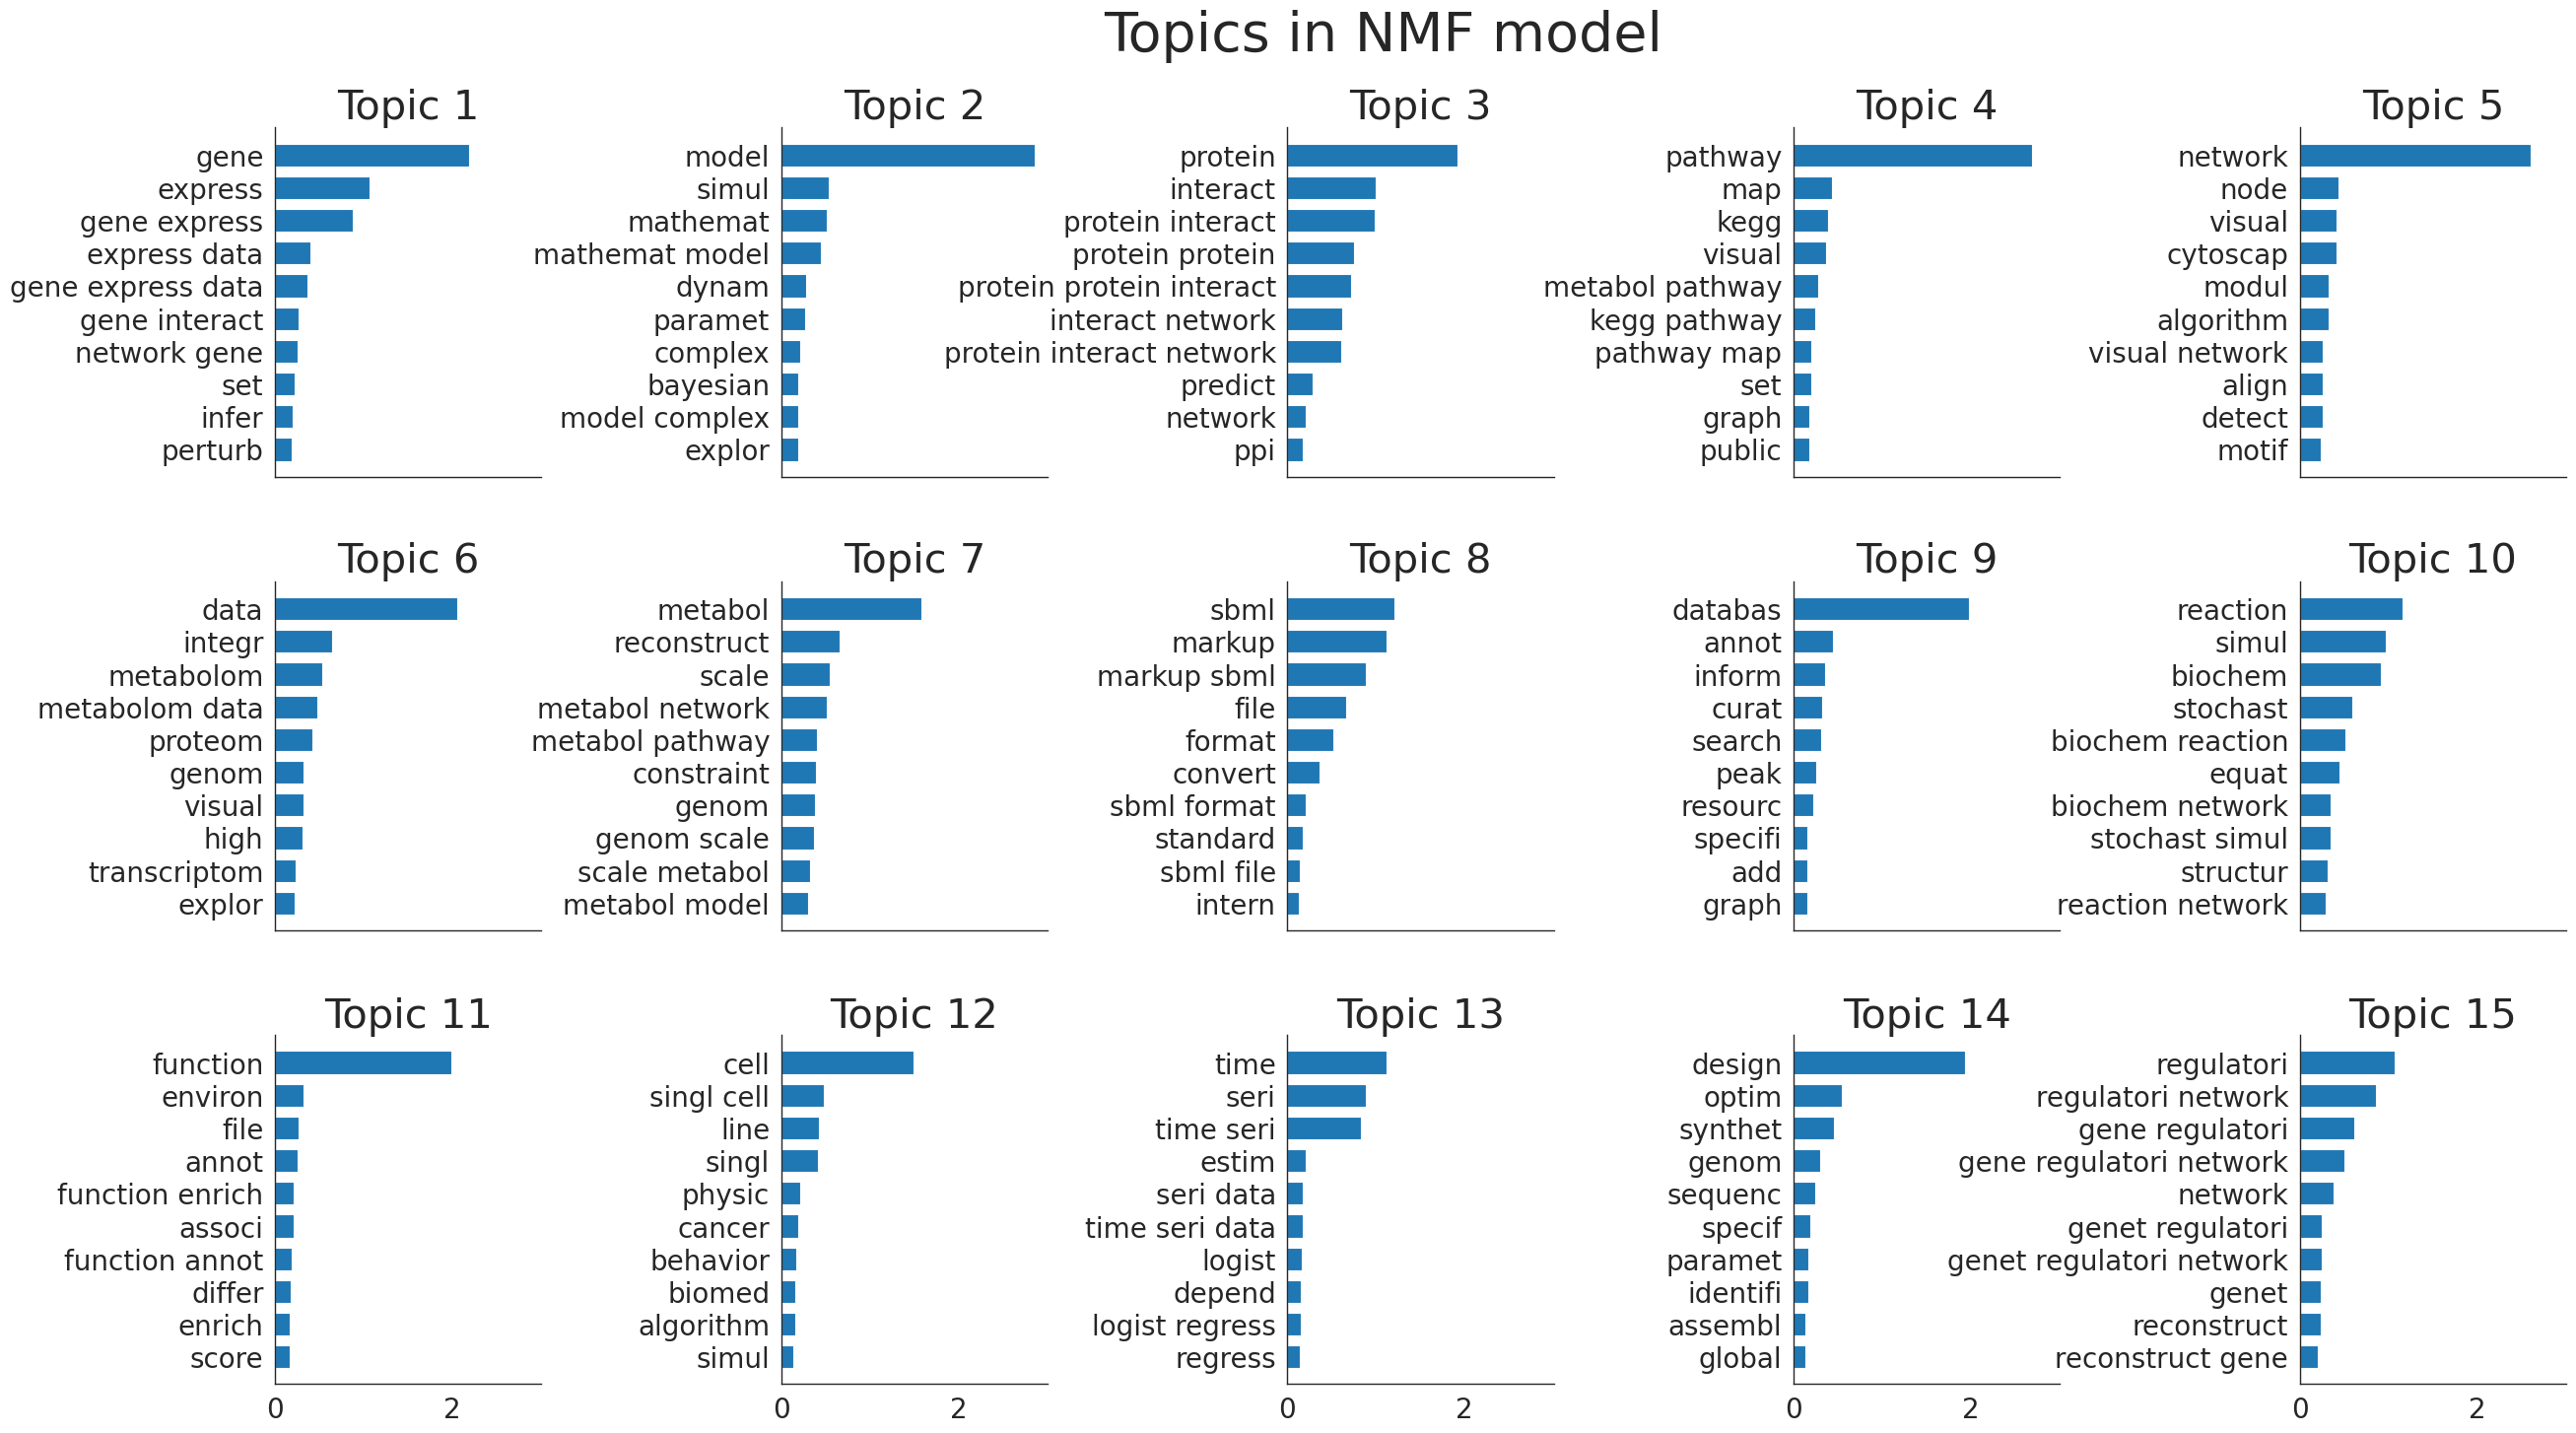

In [35]:
with (
    sns.axes_style("white"), 
    sns.plotting_context("paper")
):

    plot_top_words(
        nmf, feature_names, n_top_words, "Topics in NMF model", ncols=5
    )

We can clearly see topics extracted that relate to systems biology analysis approaches, and using an LLM can give them meaningful titles:


| Topic # | Title                                                                |
| ------- | -------------------------------------------------------------------- |
| 1       | **Gene Expression Analysis and Network Inference**                   |
| 2       | **Bayesian and Dynamic Mathematical Modeling of Biological Systems** |
| 3       | **Protein–Protein Interaction (PPI) Network Analysis**               |
| 4       | **Pathway Mapping and Visualization (e.g., KEGG)**                   |
| 5       | **Network Motif Detection and Structural Analysis**                  |
| 6       | **Multi-Omics Data Integration and Exploration**                     |
| 7       | **Genome-Scale Metabolic Modeling and Reconstruction**               |
| 8       | **Model Standardization and SBML Interoperability**                  |
| 9       | **Biological Databases and Metadata Annotation**                     |
| 10      | **Stochastic and Deterministic Reaction Network Simulation**         |
| 11      | **Functional Enrichment and Annotation Analysis**                    |
| 12      | **Single-Cell Modeling and Biomedical Simulations**                  |
| 13      | **Regression and Time Series Analysis in Systems Biology**           |
| 14      | **Genomic Design, Assembly, and Synthetic Biology**                  |
| 15      | **Gene Regulatory Network Reconstruction and Modeling**              |




We can also associated tools to topics by fitting the identified model to the document features

In [36]:
H = nmf.fit_transform(tfidf)

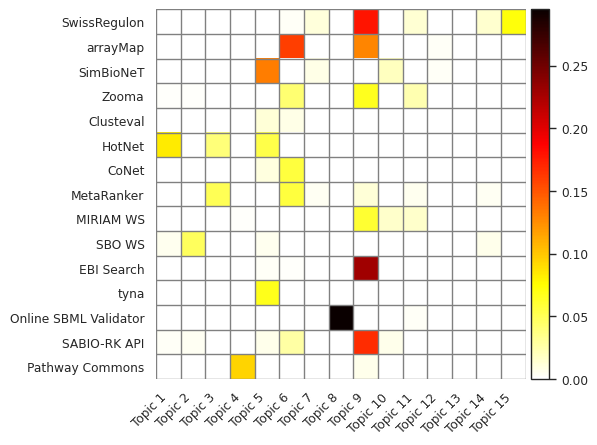

In [37]:
 # plot the first 15 tools
t = 15
h = H[:t]
labels = data["name"][:t]

with (
    sns.axes_style("white"), 
    sns.plotting_context("paper")
): 
    plot_matrix_heatmap(h, labels)